<span style="font-size:18px;">A note before starting, this notebook was run locally using GPU and due to the long time it would take to be executed again I'll be copying some of the outputs from the local notebook and put them in markdown. I hope you find the notebook beneficial, and if you have any piece of advice feel free to share it in the comments.

# Introduction

<span style="font-size:18px;"> The context of this notebook is an academic project where we were demanded to denoise images (without specifying the method). In the beginning I tried a non-ML solution that is called BM3D (Block Matching and 3D filtering), then I went ahead to experiment with the Deep Learning approach using the Auto-Encoder architecture.

# Setting up the notebook

In [3]:
!pip install bm3d

     |████████████████████████████████| 868 kB 6.3 MB/s            
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of bm3d to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 1.1 MB 50.0 MB/s            


In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import bm3d

import torch.cuda
import torch.nn as nn
from torch.nn import Linear, ReLU, MSELoss, L1Loss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, AdaptiveAvgPool2d, Module, BatchNorm2d, Sigmoid, Dropout
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision import datasets, transforms
import os

In [7]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


Is the GPU available? True

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


Device cuda

<span style="font-size:18px;">I downloaded and used the dataset available in this link : https://www.kaggle.com/greatgamedota/ffhq-face-data-set

In [23]:
data_dir =  "/kaggle/input/ffhq-face-data-set/"

In [24]:

transform = transforms.Compose([transforms.Resize(255),
                                transforms.ToTensor()
                               ])
dataset = datasets.ImageFolder(data_dir, transform=transform)
lengths = [int(len(dataset)*0.8), int(len(dataset)*0.2)]
train_dataset, val_dataset = random_split(dataset, lengths)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)

In [11]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
# Visualizing an image from the dataset
images, _ = next(iter(val_dataloader))
imshow(images[1], normalize=False)

# Expermenting with the noises

White Additive Noise :

In [ ]:
noisy_images = (images + torch.normal(0,0.2, images.shape)).clip(0,1)

In [ ]:
imshow(noisy_images[1], normalize=False)

Masking Noise :

In [ ]:
a = 0.7*torch.ones(images.shape)
bernouilli_noisy_images = images*torch.bernoulli(a)

In [ ]:
imshow(bernouilli_noisy_images[1], normalize=False)

Poisson Noise :

In [ ]:
a = 5*torch.ones(images.shape)
p = torch.poisson(a)
p_norm = p/p.max()

In [ ]:
poisson_noisy_images = (images + p_norm).clip(0,1)

In [ ]:
imshow(poisson_noisy_images[1], normalize=False)

In [ ]:
EPS = 1e-8

<span style="font-size:18px;"> These are some helper functions to evaluate the the performance of the denoising approachs:

In [ ]:
def PSNR(input, target):
    return -10*torch.log10(torch.mean((input - target) ** 2, dim=[1, 2, 3])+EPS)

In [ ]:
def MSE(input, target):
    return torch.mean((input - target) ** 2, dim=[1, 2, 3])

PSNR of Normal Noise Images :

In [ ]:
PSNR(images, noisy_images)

tensor([15.0455, 15.1718, 14.7140, 14.7304, 15.3507, 15.3572, 14.9787, 14.8285,
        14.7231, 14.9067, 15.6183, 14.5245, 14.7026, 15.0107, 14.9028, 14.9212])

PSNR of Masked Images :

In [ ]:
PSNR(images, bernouilli_noisy_images)

tensor([10.7218, 13.6338, 12.5109, 11.8838, 11.0169,  7.7124, 10.1220, 12.0363,
        11.0440,  9.5477, 16.9152,  9.7393, 11.7690, 10.0014,  9.8994, 12.6178])

PSNR of Poisson Noise Images :

In [ ]:
PSNR(images, poisson_noisy_images)

tensor([11.7429, 10.9976, 11.1412, 11.1908, 11.7629, 13.7808, 11.9429, 11.2966,
        11.3740, 12.1885, 10.8384, 11.8166, 11.2383, 12.0369, 12.0351, 11.1616])

<span style="font-size:18px;">So these scores represent a baseline for us, the models that we will create need to have a significantly higher PSNR to be taken into consideration.

# Denoising using BM3D

In [ ]:
denoised_image = bm3d.bm3d(noisy_images[1].permute(1,2,0), sigma_psd=30/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

In [ ]:
plt.imshow(denoised_image)

In [ ]:
bernouilli_denoised_image = bm3d.bm3d(bernouilli_noisy_images[1].permute(1,2,0), sigma_psd=30/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

In [ ]:
plt.imshow(bernouilli_denoised_image)

In [ ]:
poisson_denoised_image = bm3d.bm3d(poisson_noisy_images[1].permute(1,2,0), sigma_psd=15/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING).clip(0,1)

In [ ]:
plt.imshow(poisson_denoised_image)

<span style="font-size:18px;">The BM3D method has given a significant improvement when used for the normal noise, but for the other two noises it wasn't as remarkable.

<span style="font-size:18px;">(You can find a comparative illustrative in the end of the notebook)

# Denoising using Deep Learning

## Autoencoders

In [ ]:
class autoencoders(nn.Module):
    def __init__(self):
        super(autoencoders, self).__init__()
        self.encoder = Sequential(
            Conv2d(3, 32, kernel_size = (3,3), padding = "same"),
            ReLU(),
            MaxPool2d((2,2), padding = 0),
            Conv2d(32, 64, kernel_size = (3,3), padding = "same"),
            ReLU(),
            MaxPool2d((2,2), padding = 0),
            Conv2d(64, 128, kernel_size = (3,3), padding = "same"),
            ReLU(),
            MaxPool2d((2,2), padding = 0)
        )
        self.decoder = Sequential(
            ConvTranspose2d(128, 128, kernel_size = (3,3), stride = 2, padding = 0),
            ReLU(),
            ConvTranspose2d(128, 64, kernel_size = (3,3), stride = 2, padding = 0),
            ReLU(),
            ConvTranspose2d(64, 32, kernel_size = (3,3), stride = 2, padding = 0),
            ReLU(),
            ConvTranspose2d(32, 3, kernel_size = (3,3), stride = 1, padding = 1),
            Sigmoid()
        )
        
    def forward(self, images):
        x = self.encoder(images)
        x = self.decoder(x)
        return x

In [ ]:
print(summary(autoencoders(), torch.zeros((1,3,255,255))))

Layer (type)  Output Shape  Param #  Tr. Param #<br>
================================================<br>
             Conv2d-1     [1, 32, 255, 255]             896             896<br>
               ReLU-2     [1, 32, 255, 255]               0               0<br>
          MaxPool2d-3     [1, 32, 127, 127]               0               0<br>
             Conv2d-4     [1, 64, 127, 127]          18,496          18,496<br>
               ReLU-5     [1, 64, 127, 127]               0               0<br>
          MaxPool2d-6       [1, 64, 63, 63]               0               0<br>
             Conv2d-7      [1, 128, 63, 63]          73,856          73,856<br>
               ReLU-8      [1, 128, 63, 63]               0               0<br>
          MaxPool2d-9      [1, 128, 31, 31]               0               0<br>
   ConvTranspose2d-10      [1, 128, 63, 63]         147,584         147,584<br>
              ReLU-11      [1, 128, 63, 63]               0               0<br>
   ConvTranspose2d-12     [1, 64, 127, 127]          73,792          73,792<br>
              ReLU-13     [1, 64, 127, 127]               0               0<br>
   ConvTranspose2d-14     [1, 32, 255, 255]          18,464          18,464<br>
              ReLU-15     [1, 32, 255, 255]               0               0<br>
   ConvTranspose2d-16      [1, 3, 255, 255]             867             867<br>
           Sigmoid-17      [1, 3, 255, 255]               0               0<br>
=================================================<br>
Total params: 333,955<br>
Trainable params: 333,955<br>
Non-trainable params: 0<br>
----------------------------------------------------------------------------<br>

In [ ]:
loss_module = MSELoss()

In [ ]:
def eval_model(model, val_dataloader, noise_type, noise_parameter):
    model.eval()
    psnr = []
    mse = []
    with torch.no_grad():
        for images, _ in val_dataloader:
            if (noise_type == "normal"):
                noisy_images = (images + torch.normal(0,noise_parameter,images.shape)).clip(0,1)
            elif (noise_type == "bernoulli"):
                a = noise_parameter*torch.ones(images.shape)
                noisy_images = images*torch.bernoulli(a)
            elif (noise_type == "poisson"):
                a = noise_parameter*torch.ones(images.shape)
                p = torch.poisson(a)
                p_norm = p/p.max()
                noisy_images = (images + p_norm).clip(0,1)
            images = images.to(device)
            noisy_images = noisy_images.to(device)
            preds = model(images)
            psnr.extend(PSNR(images.cpu().detach(), preds.cpu().detach()))
            mse.extend(MSE(images.cpu().detach(), preds.cpu().detach()))
        print(f"Peak Signal to Noise Ratio:   Mean: {np.array(psnr).mean()} || Std: {np.array(psnr).std()}")
        print(f"Mean Squared Error:   Mean: {np.array(mse).mean()} || Std: {np.array(mse).std()}")
        return np.array(psnr).mean(), np.array(mse).mean()

In [ ]:
def train_model(model, noise_type, noise_parameter, optimizer, train_dataloader, val_dataloader, loss_module, target_type="clean", num_epochs=30):
    model.train()
    epoch_num = []
    mse_train = []
    mse_val = []
    psnr_train = []
    psnr_val = []
    mse = 0.0
    psnr = 0.0
    for epoch in range(num_epochs):
        for images, _ in train_dataloader:
            targets = torch.clone(images)
            if (noise_type == "normal"):
                images = (images + torch.normal(0,noise_parameter,images.shape)).clip(0,1)
            elif (noise_type == "bernoulli"):
                a = noise_parameter*torch.ones(images.shape)
                images = images*torch.bernoulli(a)
            elif (noise_type == "poisson"):
                a = noise_parameter*torch.ones(images.shape)
                p = torch.poisson(a)
                p_norm = p/p.max()
                images = (images + p_norm).clip(0,1)
            if (target_type == "noisy"):
                if (noise_type == "normal"):
                    targets = (targets + torch.normal(0,noise_parameter,targets.shape)).clip(0,1)
                elif (noise_type == "bernoulli"):
                    a = noise_parameter*torch.ones(targets.shape)
                    targets = targets*torch.bernoulli(a)
                elif (noise_type == "poisson"):
                    a = noise_parameter*torch.ones(targets.shape)
                    p = torch.poisson(a)
                    p_norm = p/p.max()
                    targets = (targets + p_norm).clip(0,1)           
            images = images.to(device)
            targets = targets.to(device)
            preds = model(images)
            loss = loss_module(preds, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch%3 == 0):
            print(f"********EPOCH {epoch+1}:********")
            epoch_num.append(epoch+1)
            print("Train set:")
            psnr, mse = eval_model(model, train_dataloader, noise_type, noise_parameter)
            psnr_train.append(psnr)
            mse_train.append(mse)
            print("Validation set:")
            psnr, mse = eval_model(model, val_dataloader, noise_type, noise_parameter)
            
            psnr_val.append(psnr)
            mse_val.append(mse)

<span style="font-size:18px;">In the training and validation functions I've taken into consideration various noise types to make it easier if we want to generalize a model by training it each time on a different type and with different parameters.

In [ ]:
normal_ae_mse = autoencoders()
normal_optimizer_mse = optim.Adam(normal_ae_mse.parameters(), lr=1e-3)
normal_ae_mse = normal_ae_mse.to(device)

In [ ]:
bernoulli_ae = autoencoders()
bernoulli_optimizer = optim.Adam(bernoulli_ae.parameters(), lr=1e-3)
bernoulli_ae = bernoulli_ae.to(device)

In [ ]:
poisson_ae = autoencoders()
poisson_optimizer = optim.Adam(poisson_ae.parameters(), lr=1e-3)
poisson_ae = poisson_ae.to(device)

In [ ]:
%%time
train_model(normal_ae_mse, "normal", 0.2, normal_optimizer_mse, train_dataloader, val_dataloader, loss_module)

In [ ]:
ae = autoencoders()
ae = ae.to(device)

In [ ]:
normal_ae.eval()

In [ ]:
images, _ = next(iter(train_dataloader))
images = images.float().to(device)
output = normal_ae(images)

In [ ]:
imshow(images[1].cpu().detach(), normalize=False)

In [ ]:
images = (images + torch.normal(0,0.2,images.shape)).clip(0,1)

In [ ]:
imshow(images[1], normalize=False)

In [ ]:
output = normal_ae_mse(images.to(device))

In [ ]:
imshow(output[1].cpu().detach(), normalize=False)

In [ ]:
images, _ = next(iter(val_dataloader))
images = images.float().to(device)
output = normal_ae_mse(images)

In [ ]:
imshow(images[1].cpu().detach(), normalize = False)

In [ ]:
noisy_images = (images + torch.normal(0,0.2,images.shape).to(device)).clip(0,1)

In [ ]:
imshow(noisy_images[1].cpu().detach(), normalize = False)

In [ ]:
output = normal_ae_mse(images)

In [ ]:
imshow(output[1].cpu().detach(), normalize=False)

In [ ]:
MSE(images, output)

In [ ]:
PSNR(images, output)

In [ ]:
a = 5*torch.ones(images.shape)
p = torch.poisson(a)
p_norm = p/p.max()
images = (images + p_norm.to(device)).clip(0,1)

In [ ]:
imshow(images[1].cpu().detach(), normalize=False)

In [ ]:
output = normal_ae_mse(images)

In [ ]:
imshow(output[1].cpu().detach(), normalize=False)

<span style="font-size:18px;">The model actually gave a good, but quite oversmoothed, result on a Poisson-Noisy image even though it wasn't trained on it.

In [ ]:
normal_noisy_ae = autoencoders()
normal_noisy_optimizer = optim.Adam(normal_noisy_ae.parameters(), lr=1e-2)
normal_noisy_ae = normal_noisy_ae.to(device)

In [ ]:
%%time
train_model(normal_noisy_ae, "noisy", 0.2, normal_noisy_optimizer, train_dataloader, loss_module)

<span style="font-size:18px;">Here I actually wanted to try an idea presented by J.Lehtinen et al. in the paper "Noise2Noise: Learning Image Restoration without Clean Data" ; basically providing noisy target and the optimization problem would lead the model to find the clean representation based on the hypothesis that the noise is centered.

In [ ]:
images = images.float().to(device)
output = normal_noisy_ae(images)

In [ ]:
imshow(images[1].cpu().detach(), normalize=False)

In [ ]:
imshow(output[1].cpu().detach(), normalize=False)

In [ ]:
images = (images + torch.normal(0,0.2,images.shape).to(device)).clip(0,1)

In [ ]:
imshow(images[1].cpu().detach(), normalize=False)

In [ ]:
output = normal_noisy_ae(images)

In [ ]:
imshow(output[1].cpu().detach(), normalize=False)

<span style="font-size:18px;">Unfortunately, after training for a long time (around 6 hours), the model wasn't able to provide the desired result. This can be due to the limited size of the model or the number of the training epochs.

In [ ]:
normal_noisy_optimizer = optim.Adam(normal_noisy_ae.parameters(), lr=0.005)

In [ ]:
%%time
train_model(normal_noisy_ae, "clean", 0.2, normal_noisy_optimizer, train_dataloader, loss_module, num_epochs = 10)

In [ ]:
imshow(images[1].cpu().detach(), normalize=False)

In [ ]:
noisy_images = (images + torch.normal(0,0.2,images.shape)).clip(0,1).to(device)

In [ ]:
imshow(noisy_images[1].cpu().detach(), normalize=False)

In [ ]:
output = normal_noisy_ae(noisy_images)

In [ ]:
imshow(output[1].cpu().detach(), normalize=False)

<span style="font-size:18px;">I trained the model this time on clean target (keeping the same model that was trained on noisy data), but it seems like there is no hope with it so we decided to move on from the idea.

In [ ]:
# Saving the weights of the first model
state_dict = normal_ae_mse.state_dict()
print(state_dict)

In [ ]:
loss_module = L1Loss()

In [ ]:
normal_ae_mae = autoencoders()
normal_optimizer_mae = optim.Adam(normal_ae_mae.parameters(), lr=1e-3)
normal_ae_mae = normal_ae_mae.to(device)

In [ ]:
%%time
train_model(normal_ae_mae, "normal", 0.2, normal_optimizer_mae, train_dataloader, val_dataloader, loss_module)

<span style="font-size:18px;">We trained the second model (same architecture but different loss function).

In [ ]:
images = images.float().to(device)

In [ ]:
imshow(images[1].cpu().detach(), normalize = False)

In [ ]:
output = normal_ae_mae(images)

In [ ]:
imshow(output[1].cpu().detach(), normalize = False)

In [ ]:
noisy_images = (images.cpu().detach() + torch.normal(0,0.2,images.shape)).clip(0,1).to(device)

In [ ]:
imshow(noisy_images[1].cpu().detach(), normalize = False)

In [ ]:
output = normal_ae_mae(noisy_images)

In [ ]:
imshow(output[1].cpu().detach(), normalize = False)

In [ ]:
state_dict = torch.load("normal_ae_mse_30epochs.tar")
normal_ae_mse = autoencoders()
normal_ae_mse.load_state_dict(state_dict)

In [ ]:
normal_ae_mse = normal_ae_mse.to(device)

In [ ]:
output1 = normal_ae_mse(noisy_images)

In [ ]:
imshow(output1[1].cpu().detach(), normalize = False)

In [ ]:
state_dict = normal_mae.state_dict()

## Results from the Auto-Encoder Models

In [ ]:
normal_ae_mse = autoencoders()
state_dict = torch.load("normal_ae_mse_30epochs.tar")
normal_ae_mse.load_state_dict(state_dict)

In [ ]:
normal_ae_mse = normal_ae_mse.to(device)

In [ ]:
psnr = []
with torch.no_grad():
        for i, (images, _) in enumerate(val_dataloader):
            noisy_images = (images + torch.normal(0,0.2,images.shape)).clip(0,1)
            noisy_images = noisy_images.to(device)
            images = images.to(device)
            preds = normal_ae_mse(noisy_images)
            if (i<4):
                print(PSNR(images.cpu().detach(), preds.cpu().detach()))
            psnr.extend(PSNR(images.cpu().detach(), preds.cpu().detach()))

In [ ]:
mse_psnr = psnr.copy()

In [ ]:
mse_psnr = np.array(mse_psnr)

In [ ]:
print(f"The mean of the PSNR is {mse_psnr.mean()} and the standard deviation of the PSNR is {mse_psnr.std()}")

The mean of the PSNR is 31.12668800354004 and the standard deviation of the PSNR is 1.1921919584274292

In [ ]:
normal_ae_mae = autoencoders()
state_dict = torch.load("normal_ae_mae_30epochs.tar")
normal_ae_mae.load_state_dict(state_dict)

In [ ]:
normal_ae_mae = normal_ae_mae.to(device)

In [ ]:
psnr = []
with torch.no_grad():
        for i, (images, _) in enumerate(val_dataloader):
            noisy_images = (images + torch.normal(0,0.2,images.shape)).clip(0,1)
            noisy_images = noisy_images.to(device)
            images = images.to(device)
            preds = normal_ae_mae(noisy_images)
            if (i<4):
                print(PSNR(images.cpu().detach(), preds.cpu().detach()))
            psnr.extend(PSNR(images.cpu().detach(), preds.cpu().detach()))

In [ ]:
mae_psnr = np.array(psnr.copy())
print(f"The mean of the PSNR is {mae_psnr.mean()} and the standard deviation of the PSNR is {mae_psnr.std()}")

The mean of the PSNR is 31.070117950439453 and the standard deviation of the PSNR is 1.2800648212432861

In [ ]:
psnr=[]
for i, (images, _) in enumerate(val_dataloader):
    noisy_images = (images + torch.normal(0,0.2,images.shape)).clip(0,1)
    for j in range(images.shape[0]):
        psnr.append(PSNR(images[j,:,:,:].unsqueeze(0), torch.tensor(bm3d.bm3d(noisy_images[j,:,:,:].permute(1,2,0), sigma_psd=30/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)).permute(2,0,1).unsqueeze(0)))
    if (i<4):
        print(psnr)

In [ ]:
bm3d_psnr = torch.tensor(psnr.copy())
print(f"The mean of the PSNR is {bm3d_psnr.mean()} and the standard deviation of the PSNR is {bm3d_psnr.std()}")

The mean of the PSNR is 23.5729346128809 and the standard deviation of the PSNR is 0.4025119048011183


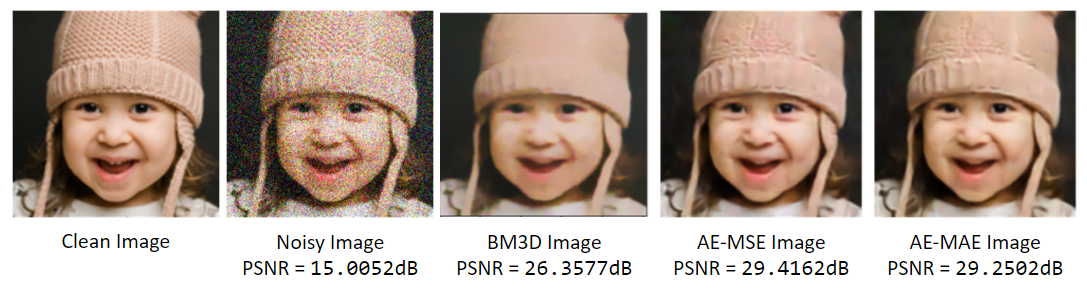